In [1]:
import time
start0 = time.time()

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils import resample
from collections import Counter

upsample_flag = 1   #1: Minor class upsampled; 2: Major class downsampled; 3: Baseline dataset

num_cv = 3
random_state_ = 42

%matplotlib inline
print('Dataset Value: {}' .format(upsample_flag))

Dataset Value: 1


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Preprocessing 

Data for this project was obtained from IBM.

In [2]:
#https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/
url = 'http://bit.ly/gta-mlnd-capstone'
df = pd.read_csv(url)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [6]:
#By setting errors to 'coerce' a 'NaN will be inserted when there is an error.
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_numeric.html

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

In [7]:
df['MonthlyCharges'].isnull().sum()

0

In [8]:
df['TotalCharges'].isnull().sum()

11

In [9]:
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [10]:
index_row = []
for index, row in df.iterrows():
    try:
        if pd.isnull(row['TotalCharges']):
            df.set_value(index, 'TotalCharges', row['MonthlyCharges'])
            print(index)
    except:
        index_row.append(row)

488
753
936
1082
1340
3331
3826
4380
5218
6670
6754


In [11]:
len(index_row)

0

In [12]:
df[df['tenure'] == 1].head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,...,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes
22,1066-JKSGK,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes


In [13]:
df['ratio'] = df['TotalCharges'] / df['MonthlyCharges']

In [14]:
df_tenure_1 = df[df['tenure'] == 1]
df_tenure_1.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ratio
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1.0
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,...,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes,1.0
22,1066-JKSGK,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes,1.0
27,8665-UTDHZ,Male,0,Yes,Yes,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,No,Electronic check,30.20,30.20,Yes,1.0
33,7310-EGVHZ,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),20.20,20.20,No,1.0
34,3413-BMNZE,Male,1,No,No,1,Yes,No,DSL,No,...,No,No,No,Month-to-month,No,Bank transfer (automatic),45.25,45.25,No,1.0
70,2273-QCKXA,Male,0,No,No,1,Yes,No,DSL,No,...,Yes,No,No,Month-to-month,No,Mailed check,49.05,49.05,No,1.0
80,5919-TMRGD,Female,0,No,Yes,1,Yes,No,Fiber optic,No,...,No,Yes,No,Month-to-month,Yes,Electronic check,79.35,79.35,Yes,1.0
91,2424-WVHPL,Male,1,No,No,1,Yes,No,Fiber optic,No,...,Yes,No,No,Month-to-month,No,Electronic check,74.70,74.70,No,1.0
100,6380-ARCEH,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.20,20.20,No,1.0


In [15]:
df[df['tenure'] == 2].head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ratio
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2.008357
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2.144979
31,4929-XIHVW,Male,1,Yes,No,2,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),95.50,181.65,No,1.902094


In [16]:
df.iloc[4]['MonthlyCharges'] * df.iloc[4]['tenure']

141.4

In [17]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,ratio
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.798992,32.374993
std,0.368612,24.559481,30.090047,2266.730170,24.593918
min,0.000000,0.000000,18.250000,18.800000,1.000000
25%,0.000000,9.000000,35.500000,398.550000,8.717230
50%,0.000000,29.000000,70.350000,1394.550000,28.673115
75%,0.000000,55.000000,89.850000,3786.600000,55.244460
max,1.000000,72.000000,118.750000,8684.800000,79.341772


In [18]:
print('The total number of customers who did not churn: {}' .format(df['Churn'].value_counts()[0]))
print('The total number of customers who did churn: {}' .format(df['Churn'].value_counts()[1]))

The total number of customers who did not churn: 5174
The total number of customers who did churn: 1869


In [19]:
Q1 = np.percentile(df['MonthlyCharges'], 25)
Q3 = np.percentile(df['MonthlyCharges'], 75)

step = 1.5 * (Q3 - Q1)
    
print('The 25% quartile: {}'.format(format(Q1)))
print('The 75% quartile: {}'.format(format(Q3)))
print("1.5 * IQR: {}" .format(step))

print(Q1 - step)
print(Q3 + step)
print(df['MonthlyCharges'].max())
print(df['TotalCharges'].min())

The 25% quartile: 35.5
The 75% quartile: 89.85
1.5 * IQR: 81.52499999999999
-46.02499999999999
171.375
118.75
18.8


In [20]:
Q1 = np.percentile(df['TotalCharges'], 25)
Q3 = np.percentile(df['TotalCharges'], 75)

step = 1.5 * (Q3 - Q1)
    
print('25%: {}'.format(Q1))
print('75%: {}'.format(Q3))
print("1.5 * IQR: {}" .format(step))

print(Q1 - step)
print(Q3 + step)
print(df['TotalCharges'].max())
print(df['TotalCharges'].min())

25%: 398.55
75%: 3786.6
1.5 * IQR: 5082.075
-4683.525
8868.675
8684.8
18.8


In [21]:
df.columns.tolist()

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'ratio']

In [22]:
features = df[[
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']]

In [23]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
Partner             7043 non-null object
Dependents          7043 non-null object
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
dtypes: object(14)
memory usage: 770.4+ KB


In [24]:
columns_list = df.columns.tolist()

In [25]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ratio
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1.000000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,33.178227
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2.008357
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,43.516548
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2.144979


In [26]:
sub_index = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]
sub_list = [columns_list[x] for x in sub_index]

In [27]:
sub_list

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [28]:
unique_ = []
for i in sub_list:
    unique_.append(df[i].unique())
type(unique_)

list

In [29]:
df_col_summary = pd.DataFrame({'Column_Header' : sub_list, 'Initial_Index': sub_index, 'Unique_Fields' : unique_})   
df_col_summary

,Column_Header,Initial_Index,Unique_Fields
0,customerID,0,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC..."
1,gender,1,"[Female, Male]"
2,SeniorCitizen,2,"[0, 1]"
3,Partner,3,"[Yes, No]"
4,Dependents,4,"[No, Yes]"
5,PhoneService,6,"[No, Yes]"
6,MultipleLines,7,"[No phone service, No, Yes]"
7,InternetService,8,"[DSL, Fiber optic, No]"
8,OnlineSecurity,9,"[No, Yes, No internet service]"
9,OnlineBackup,10,"[Yes, No, No internet service]"


In [30]:
df_cat = df[sub_list]

In [31]:
df_cat.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [32]:
df_cont = df[[ 'MonthlyCharges', 'TotalCharges', 'customerID']]
df_cont.head()

,MonthlyCharges,TotalCharges,customerID
0,29.85,29.85,7590-VHVEG
1,56.95,1889.50,5575-GNVDE
2,53.85,108.15,3668-QPYBK
3,42.30,1840.75,7795-CFOCW
4,70.70,151.65,9237-HQITU


In [33]:
df_cont.shape

(7043, 3)

In [34]:
sub_index_without_id = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]

In [35]:
df_cat = df.iloc[:, sub_index_without_id]

In [36]:
df_cat.shape

(7043, 18)

In [37]:
df_cat.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [38]:
reduced_col = df_cat.columns.tolist()[1:]

In [39]:
df_cat_ohe_id = pd.get_dummies(data=df_cat, columns=reduced_col)

In [40]:
df_cat_ohe_id.shape

(7043, 46)

In [41]:
df_cont.head()

,MonthlyCharges,TotalCharges,customerID
0,29.85,29.85,7590-VHVEG
1,56.95,1889.50,5575-GNVDE
2,53.85,108.15,3668-QPYBK
3,42.30,1840.75,7795-CFOCW
4,70.70,151.65,9237-HQITU


In [42]:
df_full = pd.concat([df_cat_ohe_id, df_cont], axis=1, join='inner')

In [43]:
df_full.shape

(7043, 49)

In [44]:
df_full['TotalCharges'].shape

(7043,)

In [45]:
df_full['MonthlyCharges'].shape

(7043,)

In [46]:
df_full.head()

,customerID,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes,MonthlyCharges,TotalCharges,customerID
0,7590-VHVEG,1,0,1,0,0,1,1,0,1,...,1,0,0,1,0,1,0,29.85,29.85,7590-VHVEG
1,5575-GNVDE,0,1,1,0,1,0,1,0,0,...,0,0,0,0,1,1,0,56.95,1889.50,5575-GNVDE
2,3668-QPYBK,0,1,1,0,1,0,1,0,0,...,1,0,0,0,1,0,1,53.85,108.15,3668-QPYBK
3,7795-CFOCW,0,1,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,42.30,1840.75,7795-CFOCW
4,9237-HQITU,1,0,1,0,1,0,1,0,0,...,1,0,0,1,0,0,1,70.70,151.65,9237-HQITU


In [47]:
df_vect = df_full.drop(['customerID'], axis=1)

In [48]:
df_vect.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes,MonthlyCharges,TotalCharges
0,1,0,1,0,0,1,1,0,1,0,...,0,1,0,0,1,0,1,0,29.85,29.85
1,0,1,1,0,1,0,1,0,0,1,...,1,0,0,0,0,1,1,0,56.95,1889.50
2,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,1,53.85,108.15
3,0,1,1,0,1,0,1,0,1,0,...,1,0,1,0,0,0,1,0,42.30,1840.75
4,1,0,1,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,1,70.70,151.65


In [49]:
df_vect.columns.tolist()

['gender_Female',
 'gender_Male',
 'SeniorCitizen_0',
 'SeniorCitizen_1',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'Paym

In [50]:
df_full = df_full[['gender_Female',
 'gender_Male',
 'SeniorCitizen_0',
 'SeniorCitizen_1',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'MonthlyCharges',
 'TotalCharges', 'Churn_No',
 'Churn_Yes']]

In [51]:
df_full.columns.tolist()[:-2]

['gender_Female',
 'gender_Male',
 'SeniorCitizen_0',
 'SeniorCitizen_1',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'Paym

In [52]:
df_full.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges,Churn_No,Churn_Yes
0,1,0,1,0,0,1,1,0,1,0,...,0,1,0,0,1,0,29.85,29.85,1,0
1,0,1,1,0,1,0,1,0,0,1,...,1,0,0,0,0,1,56.95,1889.50,1,0
2,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,1,53.85,108.15,0,1
3,0,1,1,0,1,0,1,0,1,0,...,1,0,1,0,0,0,42.30,1840.75,1,0
4,1,0,1,0,1,0,1,0,0,1,...,0,1,0,0,1,0,70.70,151.65,0,1


In [53]:
df_full_ = df_full = df_full.drop(['Churn_No'], axis=1)

In [54]:
df_full_.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges,Churn_Yes
0,1,0,1,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,29.85,29.85,0
1,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,1,56.95,1889.50,0
2,0,1,1,0,1,0,1,0,0,1,...,0,0,1,0,0,0,1,53.85,108.15,1
3,0,1,1,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,42.30,1840.75,0
4,1,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,70.70,151.65,1


# Data up/down sampling

In [55]:
df_vect_major = df_full_[df_full_['Churn_Yes'] == 0]
df_vect_minor = df_full_[df_full_['Churn_Yes'] == 1]

In [56]:
df_vect_major.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges,Churn_Yes
0,1,0,1,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,29.85,29.85,0
1,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,1,56.95,1889.50,0
3,0,1,1,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,42.30,1840.75,0
6,0,1,1,0,1,0,0,1,0,1,...,0,0,1,0,1,0,0,89.10,1949.40,0
7,1,0,1,0,1,0,1,0,1,0,...,0,1,0,0,0,0,1,29.75,301.90,0


In [57]:
df_vect_minor.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges,Churn_Yes
2,0,1,1,0,1,0,1,0,0,1,...,0,0,1,0,0,0,1,53.85,108.15,1
4,1,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,70.70,151.65,1
5,1,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,99.65,820.50,1
8,1,0,1,0,0,1,1,0,0,1,...,0,0,1,0,0,1,0,104.80,3046.05,1
13,0,1,1,0,1,0,1,0,0,1,...,0,0,1,1,0,0,0,103.70,5036.30,1


In [58]:
print("Major Class Shape: {}" .format(df_vect_major.shape))
print("Minor Class Shape: {}" .format(df_vect_minor.shape))

Major Class Shape: (5174, 46)
Minor Class Shape: (1869, 46)


In [59]:
df_full_.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges,Churn_Yes
0,1,0,1,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,29.85,29.85,0
1,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,1,56.95,1889.50,0
2,0,1,1,0,1,0,1,0,0,1,...,0,0,1,0,0,0,1,53.85,108.15,1
3,0,1,1,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,42.30,1840.75,0
4,1,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,70.70,151.65,1


In [60]:
df_major_downsample = resample(df_vect_major, replace=True, n_samples = 1869, random_state=random_state_)

In [61]:
df_major_downsample.shape

(1869, 46)

In [62]:
df_vect_minor.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges,Churn_Yes
2,0,1,1,0,1,0,1,0,0,1,...,0,0,1,0,0,0,1,53.85,108.15,1
4,1,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,70.70,151.65,1
5,1,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,99.65,820.50,1
8,1,0,1,0,0,1,1,0,0,1,...,0,0,1,0,0,1,0,104.80,3046.05,1
13,0,1,1,0,1,0,1,0,0,1,...,0,0,1,1,0,0,0,103.70,5036.30,1


In [63]:
df_vect_major.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges,Churn_Yes
0,1,0,1,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,29.85,29.85,0
1,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,1,56.95,1889.50,0
3,0,1,1,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,42.30,1840.75,0
6,0,1,1,0,1,0,0,1,0,1,...,0,0,1,0,1,0,0,89.10,1949.40,0
7,1,0,1,0,1,0,1,0,1,0,...,0,1,0,0,0,0,1,29.75,301.90,0


In [64]:
df_downsampled = pd.concat([df_vect_minor, df_major_downsample])

In [65]:
df_downsampled.shape

(3738, 46)

In [66]:
df_downsampled.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges,Churn_Yes
2,0,1,1,0,1,0,1,0,0,1,...,0,0,1,0,0,0,1,53.85,108.15,1
4,1,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,70.70,151.65,1
5,1,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,99.65,820.50,1
8,1,0,1,0,0,1,1,0,0,1,...,0,0,1,0,0,1,0,104.80,3046.05,1
13,0,1,1,0,1,0,1,0,0,1,...,0,0,1,1,0,0,0,103.70,5036.30,1


In [67]:
df_minor_upsample = resample(df_vect_minor, replace=True, n_samples =5174, random_state=random_state_)

In [68]:
df_minor_upsample.shape

(5174, 46)

In [69]:
df_upsampled = pd.concat([df_vect_major, df_minor_upsample])

In [70]:
df_upsampled.shape

(10348, 46)

In [71]:
df_upsampled[df_full_['Churn_Yes'] == 0].shape

/Users/gta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(5174, 46)

In [72]:
df_upsampled[df_full_['Churn_Yes'] == 1].shape

/Users/gta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(5174, 46)

In [73]:
print(upsample_flag)
if upsample_flag == 1:                          #Upsample
    X = df_upsampled.drop('Churn_Yes', axis=1)
    y = df_upsampled['Churn_Yes']
elif upsample_flag == 2:                        #Downsample
    X = df_downsampled.drop('Churn_Yes', axis=1)
    y = df_downsampled['Churn_Yes']
else:                                           #Baseline
    X = df_vect.drop('Churn_Yes', axis=1)
    y = df_vect['Churn_Yes']

1


In [74]:
X.shape

(10348, 45)

In [75]:
y.shape

(10348,)

In [76]:
def learning_curves(model, X_training_data, y_training_data, model_name, num_k):
    '''
    This function creates testing and cross validation learning curves that can be used
    to assess the performance of a given model.
    
    Inputs:
    model: This is the model object being used. 
    X_training_data: This is the training data that is used for the model training.
    y_training_data: This is the actual response values for the training set.
    model_name: This is the name of the model, as a text string.
    num_k: This is the number of folks to use during the cross validation phase.
    '''
    plt.figure()

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(model, X_training_data, y_training_data, cv=num_k)

    plt.title("Learning Curves: " + model_name + " With Standard Scaler")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")

    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="b")

    plt.plot(train_sizes, 
             train_scores_mean, 
             'o-', 
             color="r", 
             label="Training score")

    plt.plot(train_sizes, 
             test_scores_mean, 
             'o-', color="b", 
             label="Cross-validation score")

    plt.ylim([0.0, 1.25])
    plt.legend(loc="best")
    return plt.show()

In [77]:
def auc_roc_curves(model, X_test_data_, y_test_data_, model_name):
    
    roc_auc  = roc_auc_score(y_test_data_, model.predict(X_test_data_))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_data_)[:,1])
    
    plt.figure()

    plt.plot(fpr, tpr, label= model_name + ' (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ' + model_name)
    plt.legend(loc="lower right")
    return plt.show()

In [78]:
def lr_coef_curves(model, X_data):
    per_var = np.round(model.coef_[0], decimals = 1)
#     labels = X_data.columns.tolist()
    plt.bar(x = range(1, len(per_var)+1), height=per_var, tick_label = X_data.columns.tolist())
    plt.xlabel('Feature', fontsize = 14)
    plt.ylabel('LR Coefficient Value', fontsize = 14)
    plt.title('LR Coefficient Values', fontsize = 14)
    plt.xticks(rotation=90)
    plt.grid(True)
    return plt.show()

In [79]:
def pca_results_(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute
    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension_1'], y=reduced_data.loc[:, 'Dimension_2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.005)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("Principal Component Plane With Original Feature Projections.", fontsize=16);
    return ax

# Data Scaling Using `StandardScaler`.

In [80]:
standard_scaler = StandardScaler()

In [81]:
print(standard_scaler.fit(X))
X_std = standard_scaler.transform(X)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [82]:
#https://chrisalbon.com/machine_learning/model_evaluation/split_data_into_training_and_test_sets/
#Tl;dr: Split the data set using train_test_split first then apply standard scaler. 

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=random_state_, 
                                                    shuffle=True, 
                                                    stratify=y)
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#This means that we don't need to run Stratified_Shuffle_Split.

In [84]:
print(standard_scaler.fit(X_train))
X_train_std_df = standard_scaler.transform(X_train)
X_test_std_df = standard_scaler.transform(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [85]:
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (6933, 45)
Shape of X_test: (3415, 45)
Shape of y_train: (6933,)
Shape of y_test: (3415,)


# Part 1: Model development and tuning using `LogisticRegression`.

In [86]:
#LR base with standard scaler
lr = LogisticRegression(random_state=random_state_)
lr.fit(X_train_std_df, y_train)
y_pred_class = lr.predict(X_test_std_df)

print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('LR coef: {}' .format(lr.coef_[0]))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.756672655232827
---
Classification Report:
             precision    recall  f1-score   support

          0       0.78      0.72      0.75      1708
          1       0.74      0.79      0.77      1707

avg / total       0.76      0.76      0.76      3415

---
LR coef: [-0.00840068  0.00840068 -0.02775597  0.02775597  0.02488711 -0.02488711
  0.0444388  -0.0444388  -0.07846192  0.07846192 -0.10335878 -0.07846192
  0.15042483 -0.39202703  0.46977678 -0.14308653  0.10417385 -0.14308653
  0.00544442  0.03972604 -0.14308653  0.07223725  0.02674428 -0.14308653
  0.08622605  0.08567923 -0.14308653  0.02625533 -0.08174047 -0.14308653
  0.19250659 -0.13897887 -0.14308653  0.25049073  0.33812112 -0.06870936
 -0.35614457 -0.08012715  0.08012715 -0.0729661  -0.1059789   0.13186991
  0.01199818 -1.01290611 -0.59461614]
---
Confusion Matrix:
[[1229  479]
 [ 352 1355]]


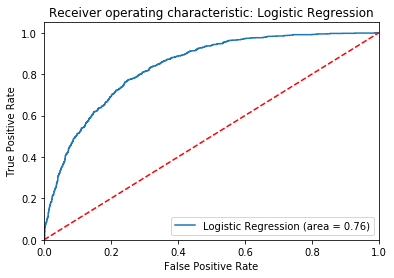

In [87]:
auc_roc_curves(lr, X_test_std_df, y_test, 'Logistic Regression')

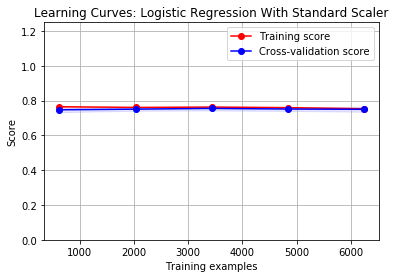

In [88]:
learning_curves(lr, X_train_std_df, y_train, 'Logistic Regression', 10)

In [89]:
#http://scikit-learn.org/0.15/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score
lr_std_scores = cross_val_score(lr, X_std, y, cv=3, scoring='recall')
lr_std_scores

array([0.79072464, 0.79536232, 0.78132251])

In [90]:
lr_grid = LogisticRegression(random_state = random_state_)
penalty = ['l1', 'l2']
C = np.logspace(0, 1, 10, 100)
hyperparameters = dict(C=C, penalty=penalty)
grid_results = GridSearchCV(lr_grid, 
                            hyperparameters, 
                            verbose=3, 
                            cv=3, 
                            scoring='recall').fit(X_train_std_df, y_train) #Will output the probability.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=1.0, penalty=l1 ...............................................
[CV] ...... C=1.0, penalty=l1, score=0.7655709342560554, total=   0.3s
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...... C=1.0, penalty=l1, score=0.7811418685121108, total=   0.5s
[CV] C=1.0, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ...... C=1.0, penalty=l1, score=0.7852813852813852, total=   0.2s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ...... C=1.0, penalty=l2, score=0.7664359861591695, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ....... C=1.0, penalty=l2, score=0.777681660899654, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ...... C=1.0, penalty=l2, score=0.7852813852813852, total=   0.1s
[CV] C=1.2915496650148839, penalty=l1 ................................
[CV]  C=1.2915496650148839, penalty=l1, score=0.7655709342560554, total=   0.3s
[CV] C=1.2915496650148839, penalty=l1 ................................
[CV]  C=1.2915496650148839, penalty=l1, score=0.7802768166089965, total=   0.7s
[CV] C=1.2915496650148839, penalty=l1 ................................
[CV]  C=1.2915496650148839, penalty=l1, score=0.7852813852813852, total=   0.3s
[CV] C=1.2915496650148839, penalty=l2 ............

[CV] ..... C=10.0, penalty=l2, score=0.7852813852813852, total=   0.1s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   29.6s finished


In [91]:
try:
    print(grid_results.best_params_)
except:
    pass

{'C': 10.0, 'penalty': 'l1'}


In [92]:
try:
    print(grid_results.best_score_) #It is assumed that this combination will yield the best performing model.
except:
    pass

0.7784824546562077


In [93]:
y_pred_class = grid_results.predict(X_test_std_df)

In [94]:
lr_ = grid_results.best_estimator_
print(lr_)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [95]:
lr_tuned = grid_results.best_estimator_

In [96]:
#https://stackoverflow.com/questions/49061575/why-when-i-use-gridsearchcv-with-roc-auc-scoring-the-score-is-different-for-gri
lr_tuned.fit(X_train_std_df, y_train)
y_pred_class = lr_tuned.predict(X_test_std_df) #Outputs the class type and not the probabilities.

print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('LR coef: {}' .format(lr_tuned.coef_[0]))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.7552087835047586
---
Classification Report:
             precision    recall  f1-score   support

          0       0.78      0.72      0.75      1708
          1       0.74      0.79      0.76      1707

avg / total       0.76      0.76      0.75      3415

---
LR coef: [-6.60110297e-04  1.64571235e-02 -5.38522353e-02  1.85648523e-03
  5.00802809e-02 -2.70424074e-05  7.83669937e-03 -8.08414486e-02
 -1.48089563e-01  5.61247895e-02 -1.15093462e-02 -8.87761765e-02
  2.89278602e-01 -3.37581107e-01  7.66892601e-01 -8.16923518e-02
  2.65786577e-01 -1.18698833e-01  1.87759106e-01  0.00000000e+00
 -1.27784264e-01  7.92182669e-02  0.00000000e+00 -1.99992989e-01
  1.05507323e-01  5.62620515e-01 -1.04120952e-01  4.87109642e-01
 -1.29910384e-01 -7.44757456e-02  2.37751309e-01 -2.12700713e-01
 -8.61353136e-02  2.70640688e-01  3.08890555e-01 -9.14476888e-02
 -3.80063811e-01 -1.67695285e-04  1.59498475e-01 -1.11564670e-02
 -4.53665455e-02  2.08904305e-01  7.58971215e-02 -1.56206800e

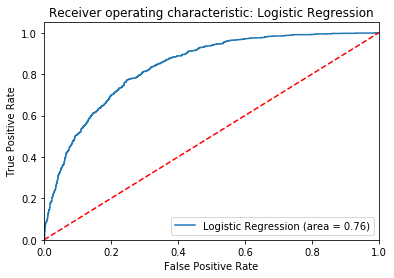

In [97]:
auc_roc_curves(lr_tuned, X_test_std_df, y_test, 'Logistic Regression')

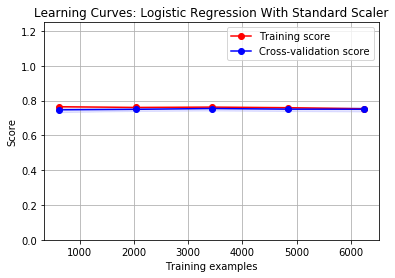

In [98]:
learning_curves(lr_tuned, X_train_std_df, y_train, 'Logistic Regression', 10)

# Part 2: Model development and tuning using `XBGClassifier`.

In [99]:
#https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
#https://github.com/dmlc/xgboost/tree/master/demo/guide-python

#XGB base with standard scaler
xgb_model = XGBClassifier(random_state=random_state_)
xgb_model.fit(X_train_std_df, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [100]:
y_pred_prob = xgb_model.predict(X_test_std_df)
y_pred_class = xgb_model.predict(X_test_std_df)

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [101]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.7760027589934819
---
Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.73      0.76      1708
          1       0.75      0.83      0.79      1707

avg / total       0.78      0.78      0.78      3415

---
Confusion Matrix:
[[1241  467]
 [ 298 1409]]


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

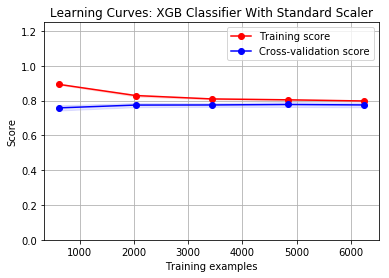

In [102]:
learning_curves(xgb_model, X_train_std_df, y_train, "XGB Classifier", 10)

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


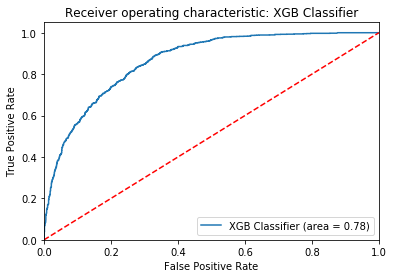

In [103]:
auc_roc_curves(xgb_model, X_test_std_df, y_test, 'XGB Classifier')

In [104]:
# https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
xgb_grid = XGBClassifier(random_state=random_state_)
learning_rate = [0.01, 0.1, 1]
max_depth = [1, 3, 5, 7]
n_estimators = [100, 1000]
hyperparameters = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
grid_results = GridSearchCV(xgb_grid, 
                            hyperparameters, 
                            verbose=3, 
                            cv=3, 
                            scoring='recall').fit(X_train_std_df, y_train) #Will output the probability.

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] learning_rate=0.01, max_depth=1, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=100, score=0.8788927335640139, total=   0.4s
[CV] learning_rate=0.01, max_depth=1, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=100, score=0.8157439446366782, total=   0.3s
[CV] learning_rate=0.01, max_depth=1, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=1, n_estimators=100, score=0.8761904761904762, total=   0.4s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, score=0.8079584775086506, total=   2.9s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, score=0.8122837370242214, total=   3.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, score=0.8025974025974026, total=   3.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=0.8304498269896193, total=   0.7s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=0.8079584775086506, total=   0.7s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=0.8303030303030303, total=   0.8s
[CV] learning_rate=0.01, max_depth=3, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=3, n_estimators=1000, score=0.8140138408304498, total=   7.2s
[CV] learning_rate=0.01, max_depth=3, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=3, n_estimators=1000, score=0.8096885813148789, total=   7.4s
[CV] learning_rate=0.01, max_depth=3, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=3, n_estimators=1000, score=0.8303030303030303, total=   7.7s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, score=0.8174740484429066, total=   1.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, score=0.8105536332179931, total=   1.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, score=0.8363636363636363, total=   1.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=1000, score=0.8434256055363322, total=  15.9s
[CV] learning_rate=0.01, max_depth=5, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=1000, score=0.8373702422145328, total=  11.0s
[CV] learning_rate=0.01, max_depth=5, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=1000, score=0.8666666666666667, total=  11.8s
[CV] learning_rate=0.01, max_depth=7, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=100, score=0.846885813148789, total=   1.9s
[CV] learning_rate=0.01, max_depth=7, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=100, score=0.8356401384083045, total=   1.8s
[CV] learning_rate=0.01, max_depth=7, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=100, score=0.8614718614718615, total=   1.8s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.8910034602076125, total=  19.8s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.8728373702422145, total=  14.8s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.9021645021645022, total=  14.8s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=1, n_estimators=100, score=0.8053633217993079, total=   0.3s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=1, n_estimators=100, score=0.8105536332179931, total=   0.3s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=1, n_estimators=100, score=0.8155844155844156, total=   0.3s
[CV] learning_rate=0.1, max_depth=1, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=1, n_estimators=1000, score=0.8001730103806228, total=   2.6s
[CV] learning_rate=0.1, max_depth=1, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=1, n_estimators=1000, score=0.8183391003460208, total=   2.7s
[CV] learning_rate=0.1, max_depth=1, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=1, n_estimators=1000, score=0.8242424242424242, total=   2.6s
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=0.8070934256055363, total=   0.7s
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=0.8131487889273357, total=   0.7s
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=0.8285714285714286, total=   0.7s
[CV] learning_rate=0.1, max_depth=3, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=3, n_estimators=1000, score=0.8598615916955017, total=   6.5s
[CV] learning_rate=0.1, max_depth=3, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=3, n_estimators=1000, score=0.8633217993079585, total=   6.5s
[CV] learning_rate=0.1, max_depth=3, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=3, n_estimators=1000, score=0.8874458874458875, total=   6.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=0.8460207612456747, total=   1.1s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=0.8382352941176471, total=   1.1s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=0.8623376623376623, total=   1.1s
[CV] learning_rate=0.1, max_depth=5, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=5, n_estimators=1000, score=0.8918685121107266, total=  10.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=5, n_estimators=1000, score=0.8987889273356401, total=  10.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=5, n_estimators=1000, score=0.9090909090909091, total=  10.4s
[CV] learning_rate=0.1, max_depth=7, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=100, score=0.879757785467128, total=   1.5s
[CV] learning_rate=0.1, max_depth=7, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=100, score=0.8633217993079585, total=   1.5s
[CV] learning_rate=0.1, max_depth=7, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=100, score=0.8943722943722944, total=   1.5s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, score=0.8814878892733564, total=  14.4s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, score=0.9013840830449827, total=  16.8s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, score=0.9082251082251083, total=  15.9s
[CV] learning_rate=1, max_depth=1, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=1, n_estimators=100, score=0.7993079584775087, total=   0.3s
[CV] learning_rate=1, max_depth=1, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=1, n_estimators=100, score=0.8148788927335641, total=   0.3s
[CV] learning_rate=1, max_depth=1, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=1, n_estimators=100, score=0.8173160173160173, total=   0.3s
[CV] learning_rate=1, max_depth=1, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=1, n_estimators=1000, score=0.8174740484429066, total=   2.6s
[CV] learning_rate=1, max_depth=1, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=1, n_estimators=1000, score=0.8157439446366782, total=   2.6s
[CV] learning_rate=1, max_depth=1, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=1, n_estimators=1000, score=0.8173160173160173, total=   3.1s
[CV] learning_rate=1, max_depth=3, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=3, n_estimators=100, score=0.8494809688581315, total=   0.7s
[CV] learning_rate=1, max_depth=3, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=3, n_estimators=100, score=0.8598615916955017, total=   0.7s
[CV] learning_rate=1, max_depth=3, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=3, n_estimators=100, score=0.8640692640692641, total=   0.8s
[CV] learning_rate=1, max_depth=3, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=3, n_estimators=1000, score=0.8711072664359861, total=   7.5s
[CV] learning_rate=1, max_depth=3, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=3, n_estimators=1000, score=0.9022491349480969, total=   6.7s
[CV] learning_rate=1, max_depth=3, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=3, n_estimators=1000, score=0.9004329004329005, total=   6.5s
[CV] learning_rate=1, max_depth=5, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=5, n_estimators=100, score=0.8745674740484429, total=   1.1s
[CV] learning_rate=1, max_depth=5, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=5, n_estimators=100, score=0.903114186851211, total=   1.1s
[CV] learning_rate=1, max_depth=5, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=5, n_estimators=100, score=0.8978354978354979, total=   1.1s
[CV] learning_rate=1, max_depth=5, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=5, n_estimators=1000, score=0.8719723183391004, total=  10.4s
[CV] learning_rate=1, max_depth=5, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=5, n_estimators=1000, score=0.9022491349480969, total=  10.5s
[CV] learning_rate=1, max_depth=5, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=5, n_estimators=1000, score=0.8952380952380953, total=  10.5s
[CV] learning_rate=1, max_depth=7, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=100, score=0.8884083044982699, total=   1.5s
[CV] learning_rate=1, max_depth=7, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=100, score=0.907439446366782, total=   1.5s
[CV] learning_rate=1, max_depth=7, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=100, score=0.9038961038961039, total=   1.5s
[CV] learning_rate=1, max_depth=7, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=1000, score=0.8788927335640139, total=  14.0s
[CV] learning_rate=1, max_depth=7, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=1000, score=0.903114186851211, total=  14.0s
[CV] learning_rate=1, max_depth=7, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  6.2min finished


[CV]  learning_rate=1, max_depth=7, n_estimators=1000, score=0.8995670995670996, total=  14.1s


In [105]:
print(grid_results.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}


In [106]:
print(grid_results.best_score_) #It is assumed that this combination will yield the best performing model.

0.8999136320600987


In [107]:
xgb_ = grid_results.best_estimator_
print(xgb_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


In [108]:
xgb_tuned = grid_results.best_estimator_

In [109]:
xgb_tuned.fit(X_train_std_df, y_train)
y_pred_class = xgb_tuned.predict(X_test_std_df)

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [110]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.8782055635357373
---
Classification Report:
             precision    recall  f1-score   support

          0       0.94      0.81      0.87      1708
          1       0.83      0.95      0.89      1707

avg / total       0.89      0.88      0.88      3415

---
Confusion Matrix:
[[1377  331]
 [  85 1622]]


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

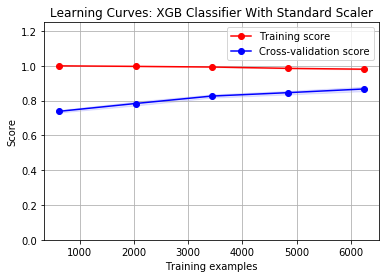

In [111]:
learning_curves(xgb_tuned, X_train_std_df, y_train, "XGB Classifier", 10)

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


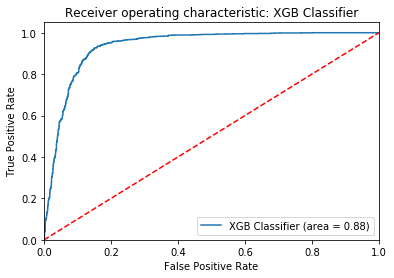

In [112]:
auc_roc_curves(xgb_tuned, X_test_std_df, y_test, 'XGB Classifier')

# Part 3: Model development and tuning using `SVC`.

In [113]:
svc_model = SVC(random_state=42, probability=True)
svc_model.fit(X_train_std_df, y_train)
y_pred_class = svc_model.predict(X_test_std_df)
#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [114]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.778343993392684
---
Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.73      0.77      1708
          1       0.76      0.82      0.79      1707

avg / total       0.78      0.78      0.78      3415

---
Confusion Matrix:
[[1253  455]
 [ 302 1405]]


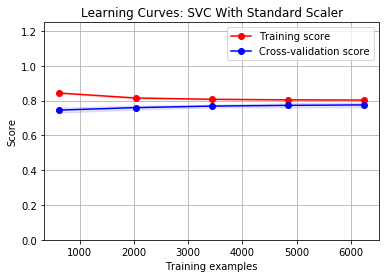

In [115]:
learning_curves(svc_model, X_train_std_df, y_train, "SVC", 10)

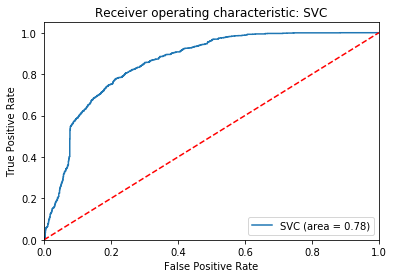

In [116]:
auc_roc_curves(svc_model, X_test_std_df, y_test, 'SVC')

In [117]:
svc_grid = SVC(random_state=random_state_, probability=True)
C = [0.001, 0.10, 0.1, 10]
gamma = [1e-2, 1e-3, 1e-4]
kernel = ['rbf', 'poly'] 
hyperparameters = dict(C=C, gamma=gamma, kernel=kernel)
grid_results = GridSearchCV(svc_grid, 
                            hyperparameters, 
                            verbose=3, 
                            cv=3, 
                            scoring='recall').fit(X_train_std_df, y_train) #Will output the probability.

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ....... C=0.001, gamma=0.01, kernel=rbf, score=1.0, total=  14.1s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.8823529411764706, total=   9.8s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.5s remaining:    0.0s


[CV] ....... C=0.001, gamma=0.01, kernel=rbf, score=1.0, total=  10.6s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV] ...... C=0.001, gamma=0.01, kernel=poly, score=1.0, total=   9.0s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV]  C=0.001, gamma=0.01, kernel=poly, score=0.948961937716263, total=   9.0s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV] ...... C=0.001, gamma=0.01, kernel=poly, score=1.0, total=  12.2s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] ...... C=0.001, gamma=0.001, kernel=rbf, score=1.0, total=  22.7s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.907439446366782, total=  18.3s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] ...... C=0.001, gamma=0.001, kernel=rbf, score=1.0, total=  15.1s
[CV] C=0.001, gamma=0.001, kernel=poly ......................

[CV]  C=10, gamma=0.01, kernel=poly, score=0.8460207612456747, total=   4.9s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV]  C=10, gamma=0.01, kernel=poly, score=0.8398268398268398, total=   4.6s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV]  C=10, gamma=0.001, kernel=rbf, score=0.8261245674740484, total=   5.9s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV]  C=10, gamma=0.001, kernel=rbf, score=0.8347750865051903, total=   6.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV]  C=10, gamma=0.001, kernel=rbf, score=0.8207792207792208, total=   6.1s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV]  C=10, gamma=0.001, kernel=poly, score=0.9982698961937716, total=   7.0s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV]  C=10, gamma=0.001, kernel=poly, score=0.948961937716263, total=   7.8s
[CV] C=10, gamma=0.001, kernel=pol

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 11.5min finished


In [118]:
print(grid_results.best_params_)

{'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}


In [119]:
print(grid_results.best_score_) #It is assumed that this combination will yield the best performing model.

0.9829873125720876


In [120]:
svc_ = grid_results.best_estimator_
print(svc_)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


In [121]:
svc_tuned = grid_results.best_estimator_

In [122]:
svc_tuned.fit(X_train_std_df, y_train)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [123]:
svc_tuned.fit(X_train_std_df, y_train)
y_pred_class = svc_tuned.predict(X_test_std_df) #Outputs the class type and not the probabilities.

In [124]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.5
---
Classification Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1708
          1       0.50      1.00      0.67      1707

avg / total       0.25      0.50      0.33      3415

---
Confusion Matrix:
[[   0 1708]
 [   0 1707]]


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


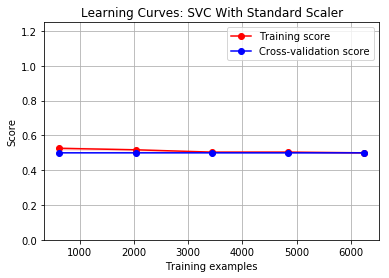

Elapsed time: 5.14 min


In [125]:
start1 = time.time()

learning_curves(svc_tuned, X_train_std_df, y_train, "SVC", 10)

end1 = time.time()
print('Elapsed time: {0:.2f} min' .format((end1 - start1)/60))

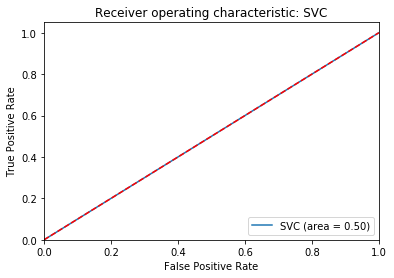

Elapsed time: 0.04 min


In [126]:
start2 = time.time()

auc_roc_curves(svc_tuned, X_test_std_df, y_test, 'SVC')

end2 = time.time()
print('Elapsed time: {0:.2f} min' .format((end2 - start2)/60))